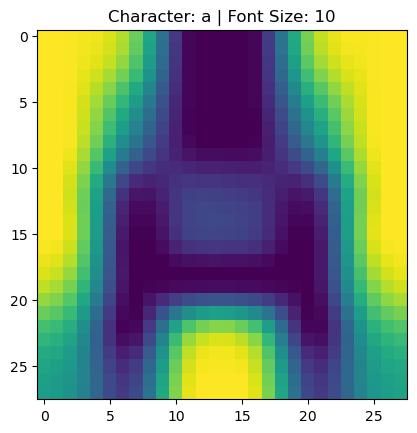

In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


'Сбор файлов шрифтов из указанной директории'
def collect_font_files(fonts_dir):
    
    font_files = []
    for root, dirs, files in os.walk(fonts_dir):
        
        for file in files:
            if file.endswith(".ttf") or file.endswith(".otf"):
                font_files.append(os.path.join(root, file))
    
    return font_files


'Генерация датасета для обучения с символами различных размеров'
def generate_chars(fonts, characters, img_size=(128, 128), min_font_size=10, max_font_size=80, output_dir="chars_samples"):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    mark = True
    char_images = []
    char_labels = []
    for font_file in fonts:
        font_name = os.path.splitext(os.path.basename(font_file))[0]
        font_output_dir = os.path.join(output_dir, font_name)
        if not os.path.exists(font_output_dir):
            os.makedirs(font_output_dir)

        for font_size in range(min_font_size, max_font_size + 1):
            font = ImageFont.truetype(font_file, size=font_size)
            for i, char in enumerate(characters):
                image = text_on_image(img_size, char, font)
                image_path = os.path.join(font_output_dir, f"{char}_{font_size}_{i}.png")
                image.save(image_path)
                
                # Выделение символа на изображении
                contours = find_contours(image)
                symbols = extract_symbols(image, contours)
                for symbol in symbols:
                    char_images.append(symbol)
                    char_labels.append(font_name)
                
                # Визуалиция вырезанного символа
                if mark == True:
                    plt.imshow(symbol)
                    plt.title(f'Character: {char} | Font Size: {font_size}')
                    plt.show()
                    mark = False

    return np.array(char_images), np.array(char_labels)


'Создание изображения с текстом'
def text_on_image(img_size, text, font):
    image = Image.new("L", img_size, color=255)
    draw = ImageDraw.Draw(image)
    text_width, text_height = draw.textsize(text, font=font)
    x = (img_size[0] - text_width) / 2
    y = (img_size[1] - text_height) / 2
    draw.text((x, y), text, font=font, fill=0)
    return image


'''Поиск контура символа
Использована в генерации датасета для обучения, 
так как в результате она используется в модуле предсказания 3_ModuleRecognition.py'''
def find_contours(char_image):
    im_array = np.array(char_image)
    if len(im_array.shape) == 3:
        im_gray = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)
    else:
        im_gray = im_array

    im_th = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    ctrs, _ = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cv2.boundingRect(ctr) for ctr in ctrs]
    return contours


'''Выделение символа из строки
Использована в генерации датасета для обучения, 
так как в результате она используется в модуле предсказания 3_ModuleRecognition.py'''
def extract_symbols(char_image, contours):
    symbols = []
    for (x, y, w, h) in contours:
        symbol = char_image.crop((x, y, x + w, y + h))
        symbol = symbol.resize((28, 28))
        symbols.append(np.array(symbol))
    return symbols


fonts_dir = "fonts"
fonts = collect_font_files(fonts_dir)

# Генерация символов chars_samples
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
images, labels = generate_chars(fonts, characters)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
np.savez("fonts_dataset.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, labels=labels)